# HNN US Data

# Import modules

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.autograd import Variable
#from torchsummary import summary
#import torch.utils.data as Data

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import copy
import itertools
import os
import time
import random
import math
import warnings

# set direcory
os.chdir('/Users/chairemacro/Dropbox/Hugo/Side_projects/learning_python/learning_session/')

# Import HNN and tools functions
from functions.HNN import HNN
import functions.TrainHNN as TrainHNN
import functions.DataProcessing as DataTools

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data management

### Import data
Data horizon : 1961Q1 - 2022Q3, the real value for 2022Q3 is not observed. 

In [2]:
# import data from csv file
data = pd.read_csv('data/dataUS.csv')

# dates vector
dates = data.iloc[:, 0]
dates = dates.astype(str)
data = data.iloc[:, 1:]

# get column names
col_names = list(data.columns)[1:]

### Data processing : Training and test set
Standardize ; Split in 2020Q1 ; Put into tensor

In [3]:
# Standardize data
oos_pos = dates[dates == "3/1/2020"].index[0] # OOS start position
X_train, X_test, y_train, y_test, y_mean, y_std = DataTools.preprocess_data(data, split_id = oos_pos, scale_y = True, scale_x = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([235, 1795]),
 torch.Size([235]),
 torch.Size([11, 1795]),
 torch.Size([11]))

### Make hemispheres (create x_pos)
Find variables position for each hemisphere

In [5]:
# Which lags to use ? (all the first part of the column name in the data)
first_part = ["L0_", "L1_", "L2_", "L3_","L1_MARX_", "L3_MARX_", "L7_MARX_"]

# Hemisphere 1 : Real activity
labor_name = ["PAYEMS", "USPRIV", "MANEMP", "SRVPRD", "USGOOD", "DMANEMP", "NDMANEMP", "USCONS", "USEHS",
              "USFIRE", "USINFO", "USPBS", "USLAH", "USSERV", "USMINE", "USTPU", "USGOVT", "USTRADE",
              "USWTRADE", "CES9091000001", "CES9092000001", "CES9093000001", "CE16OV", "CIVPART",
              "UNRATE", "UNRATESTx", "UNRATELTx", "LNS14000012", "LNS14000025", "LNS14000026",
              "UEMPLT5", "UEMP5TO14", "UEMP15T26", "UEMP27OV", "LNS13023621", "LNS13023557",
              "LNS13023705", "LNS13023569", "LNS12032194", "HOABS", "HOAMS", "HOANBS", "AWHMAN",
              "AWHNONAG", "AWOTMAN", "HWIx", "UEMPMEAN", "CES0600000007", "HWIURATIOx", "CLAIMSx",
              "GDPC1","PCECC96", "GPDIC1", "OUTNFB", "OUTBS", "OUTMS", "INDPRO", "IPFINAL", "IPCONGD", 
              "IPMAT", "IPDMAT", "IPNMAT", "IPDCONGD", "IPB51110SQ", "IPNCONGD", "IPBUSEQ", "IPB51220SQ",
              "TCU", "CUMFNS","IPMANSICS", "IPB51222S", "IPFUELS"]
hemisphere_var = DataTools.append_list(first_part, labor_name)
x_pos1 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos1)

# Hemisphere 2 : Short-run expectations
price_name = ["PCECTPI", "PCEPILFE", "GDPCTPI", "GPDICTPI", "IPDBS","CPILFESL", "CPIAPPSL","CPITRNSL",
              "CPIMEDSL", "CUSR0000SAC","CUSR0000SAD", "WPSFD49207","PPIACO", "WPSFD49502", "WPSFD4111",
              "PPIIDC", "WPSID61", "WPSID62","CUSR0000SAS", "CPIULFSL", "CUSR0000SA0L2", "CUSR0000SA0L5",
              "CUSR0000SEHC","spf_cpih1", "spf_cpi_currentYrs", "inf_mich"]
hemisphere_var = DataTools.append_list(first_part, price_name)
x_pos2 = DataTools.find_position(col_names, hemisphere_var)
x_pos2 = list(range(0,4)) + x_pos2
#print(x_pos2)

# Hemisphere 3 : Commodities
commodities_name = ["WPU0531","WPU0561", "OILPRICEx", "PPICMM"]
hemisphere_var = DataTools.append_list(first_part, commodities_name)
x_pos3 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos3)

# Hemisphere 4 : Long-run expectations
x_pos4 = [(X_train.shape[1]-1)] # trend position
#print(x_pos4)

# Put all hemisphere position together
x_pos = [x_pos1, x_pos2, x_pos3 ,x_pos4, x_pos4, x_pos4, x_pos4] # the last 3 x_pos4 are for the coefficients associated with each hemisphere

# Estimation

### Set hyperparameters

In [6]:
# Nodes in each layers
nodes = []
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 1
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 2
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 3
nodes.append(([400]*3)) # Number of neurons and hidden layers in hemisphere 4
nodes.append(([100]*3)) # Number of neurons and hidden layers for the trend in hemisphere 1
nodes.append(([100]*3)) # Number of neurons and hidden layers for the trend in hemisphere 2
nodes.append(([100]*3)) # Number of neurons and hidden layers for the trend in hemisphere 3

# Number of inputs
n_features = [len(x_pos1), len(x_pos2), len(x_pos3), 1, 1, 1, 1] # hemisphere 1, 2, 3, 4, trend 1, trend 2, trend 3

# Add a trend to the hemispheres
add_trends_to = list(range(0,3))

# Always oob postion (not included in HNN training set) : 2020Q1 - 2020Q4
ao_start = dates[dates == "3/1/2020"].index[0] 
ao_end = dates[dates == "12/1/2020"].index[0] 

# Hyperparameters list
nn_hyps = {"nodes":nodes,                   # Number of neurons and hidden layers      
           "n_features":n_features,         # Number of inputs in each hemisphere
           "dropout_rate":0.2,              # Dropout rate in each layers (same for all hemispheres)
           "add_trends_to":add_trends_to,   # Add trend (time varying coefficient) to hemispheres 1 to 3
           "x_pos":x_pos,                   # Position of the variables in each hemisphere
           "lr":0.05,                       # Learning rate
           "epochs":500,                    # Maximum number of epochs
           "patience":50,                   # Number of epochs before stopping once your loss starts to increase (Return the best model)
           "block_size":6,                  # Number of quarter the use in block bootstrap (not used if opt_bootstrap = 1)          
           "num_bootstrap":300,             # Number of bootstrap
           "opt_bootstrap":2,               # Bootstrapping types (1: Normal, 2: block bootstrap)
           "model_to_return":'last',        # Return the last model ("last") or the best model ("best") after the early stopping
           "sampling_rate":0.85,            # In-sample sampling rate
           "tol":0.01,                      # Early stopping criteria tolerance (MSE)
           "always_oob": None,              # Rows to always include in OOB ("None", to not use "always_oob" ; otherwise list(range(ao_start, ao_end+1)))
           "device":device,
           "seed":1234}

### HNN training
Train HNN using the hyperparameters in "nn_hyps"

In [7]:
results = TrainHNN.estimate_HNN(X_train, y_train, X_test, y_test, nn_hyps)

Bootstrap 0
Early stopped on epoch 96
Best epoch: 74

Bootstrap 1
Early stopped on epoch 118
Best epoch: 91

Bootstrap 2
Early stopped on epoch 81
Best epoch: 30

Bootstrap 3
Early stopped on epoch 154
Best epoch: 136

Bootstrap 4
Early stopped on epoch 107
Best epoch: 56

Bootstrap 5
Early stopped on epoch 106
Best epoch: 55

Bootstrap 6
Early stopped on epoch 107
Best epoch: 67

Bootstrap 7
Early stopped on epoch 108
Best epoch: 63

Bootstrap 8
Early stopped on epoch 74
Best epoch: 23

Bootstrap 9
Early stopped on epoch 142
Best epoch: 126

Bootstrap 10
Early stopped on epoch 133
Best epoch: 122

Bootstrap 11
Early stopped on epoch 80
Best epoch: 29

Bootstrap 12
Early stopped on epoch 114
Best epoch: 63

Bootstrap 13
Early stopped on epoch 117
Best epoch: 67

Bootstrap 14
Early stopped on epoch 98
Best epoch: 84

Bootstrap 15
Early stopped on epoch 85
Best epoch: 74

Bootstrap 16
Early stopped on epoch 113
Best epoch: 69

Bootstrap 17
Early stopped on epoch 82
Best epoch: 31

Bootst

Save the model

# Estimation results

### In-Sample and Out-of-sample (OOS)

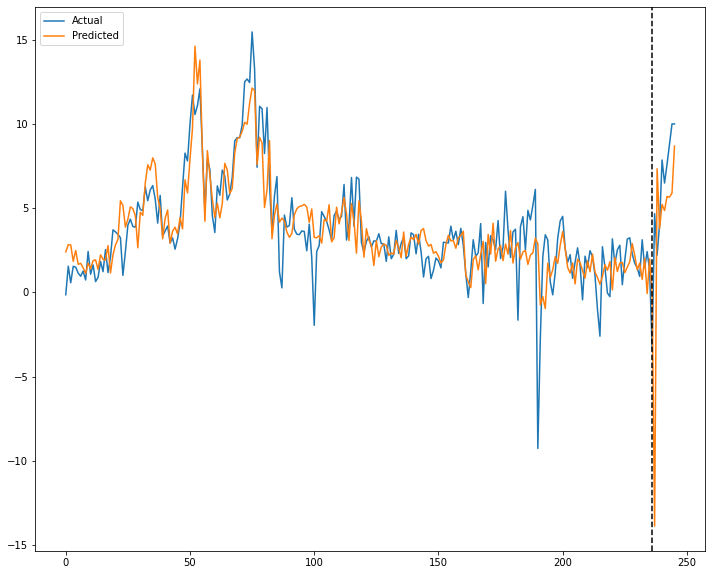

In [9]:
pred_in = results["pred_in_mean"] # In-sample (train)
pred_out = results["pred_mean"]   # OOS (test)

# Annualized in-sample
predict = np.concatenate((pred_in, pred_out), axis=0)
predict = DataTools.inverse_scaling(predict, y_mean, y_std) * 400

# Annualized OOS
real = np.concatenate((y_train, y_test), axis=0)
real = DataTools.inverse_scaling(real, y_mean, y_std) * 400

# Plot the results
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(real, label='Actual')
plt.plot(predict, label='Predicted')
plt.axvline(x=(oos_pos+1), color='black', linestyle='--')
plt.legend()
plt.show()

### Only OOS forecasts

OOS RMSE : 6.50383047977033


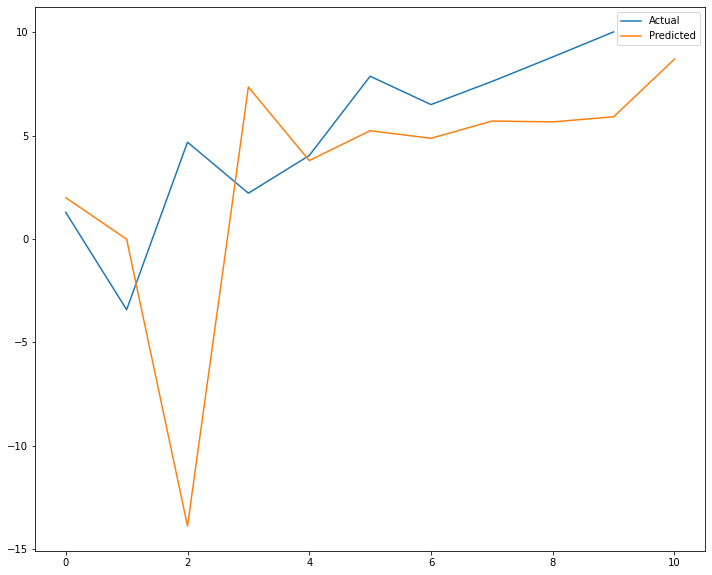

          Date  Realized  Predicted
235   3/1/2020       1.3        2.0
236   6/1/2020      -3.4       -0.0
237   9/1/2020       4.7      -13.9
238  12/1/2020       2.2        7.3
239   3/1/2021       4.0        3.8
240   6/1/2021       7.9        5.2
241   9/1/2021       6.5        4.9
242  12/1/2021       7.6        5.7
243   3/1/2022       8.8        5.7
244   6/1/2022      10.0        5.9
245   9/1/2022       NaN        8.7


In [11]:
# Realized values
realized = y_test[:-1] # Remove the last value (2022Q3)
realized = np.append(realized, np.nan) 
realized = DataTools.inverse_scaling(realized, y_mean, y_std) * 400

# Forecasted values
predicted = results["pred_mean"]
predicted = DataTools.inverse_scaling(predicted, y_mean, y_std) * 400

# Plot the results
print("OOS RMSE : " + str(math.sqrt(DataTools.MSE(realized, predicted)))) # RMSE
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(realized, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

# Put realized and predicted values in a dataframe
df = pd.DataFrame({'Date':dates[-len(realized):],
                   'Realized': realized,
                   'Predicted': predicted})
df = df.round(1)
print(df)

### Contributions

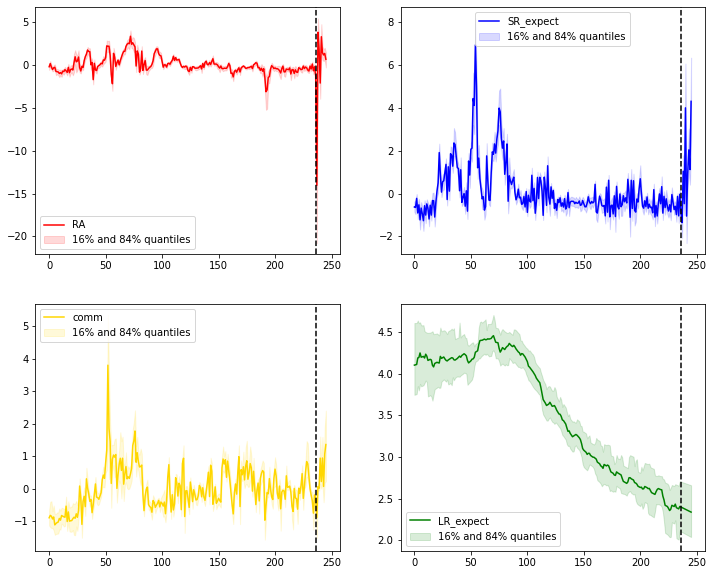

In [12]:
# Get all components
RA = np.concatenate((results['part_pred_in_mean'][:,0], results['part_pred_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,0,:],results["part_pred_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400


SR_expect = np.concatenate((results['part_pred_in_mean'][:,1], results['part_pred_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,1,:],results["part_pred_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['part_pred_in_mean'][:,2], results['part_pred_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,2,:],results["part_pred_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['part_pred_in_mean'][:,3], results['part_pred_mean'][:,3]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,3,:],results["part_pred_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

### Gaps

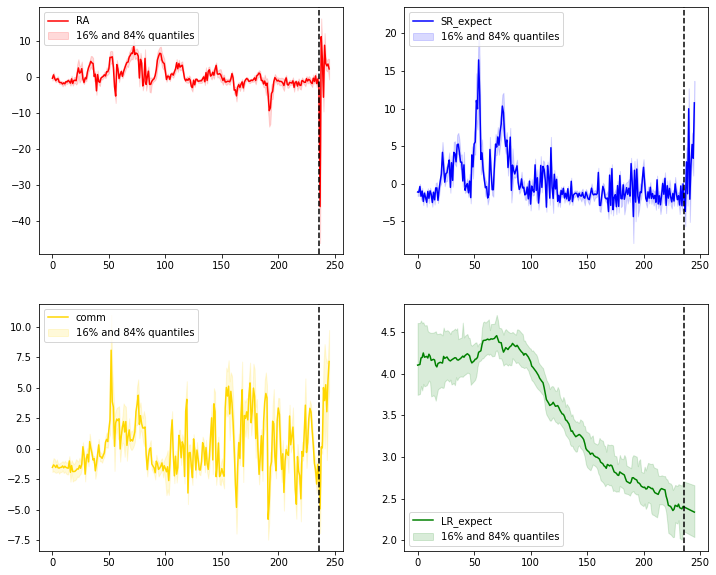

In [13]:
# Get all gaps
RA = np.concatenate((results['gaps_in_mean'][:,0], results['gaps_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["gaps_in_ensemble"][:,0,:],results["gaps_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400

SR_expect = np.concatenate((results['gaps_in_mean'][:,1], results['gaps_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,1,:],results["gaps_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['gaps_in_mean'][:,2], results['gaps_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["gaps_in_ensemble"][:,2,:],results["gaps_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['gaps_in_mean'][:,3], results['gaps_mean'][:,3]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,3,:],results["gaps_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()

### Trends (Time-varying coefficents)

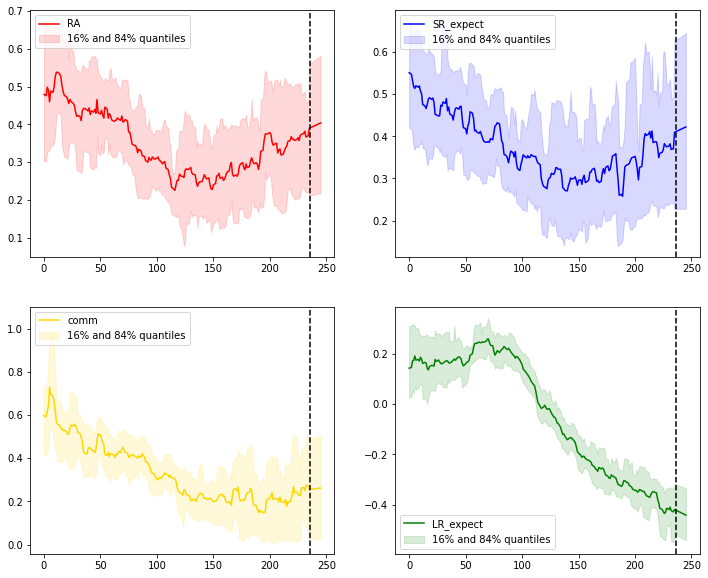

In [14]:
RA = np.concatenate((results['trends_in_mean'][:,0], results['trends_mean'][:,0]), axis=0)
RA_quantiles =  np.concatenate((results["trends_in_ensemble"][:,0,:],results["trends_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)

SR_expect = np.concatenate((results['trends_in_mean'][:,1], results['trends_mean'][:,1]), axis=0)
SR_expect_quantiles = np.concatenate((results["trends_in_ensemble"][:,1,:],results["trends_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)

comm = np.concatenate((results['trends_in_mean'][:,2], results['trends_mean'][:,2]), axis=0)
comm_quantiles = np.concatenate((results["trends_in_ensemble"][:,2,:],results["trends_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)

LR_expect = np.concatenate((results['part_pred_in_mean'][:,3], results['part_pred_mean'][:,3]), axis=0)
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,3,:],results["part_pred_ensemble"][:,3,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(2, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')
axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')
axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')
axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')
axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
plt.show()